# 2D Wave solver

Below is a program which solved the 2d wave equation on a regular grid using finite differences. 



In [2]:
%matplotlib notebook 
import math as m
import numpy #array operations
import matplotlib.pyplot as plt #plotting
from ipywidgets import widgets #for the widgets
#from ipykernel.client import display
from IPython import display #for continous display
from PIL import Image #to export images

nimg=0

def savemyimage(visual):
    global nimg
    visual = (visual +2.)/4.
    result = Image.fromarray((visual * 255).astype(numpy.uint8))
    result.save('out{:03d}.bmp'.format(nimg))
    nimg=nimg+1

def plotwave(u,time,px,py,pp,pt):
    plt.figure(1)
    plt.clf()
    plt.subplot2grid((4,4),(0,0), colspan = 4, rowspan = 3)
    plt.imshow(u, origin='upper', extent=[0., 2., 0., 2.], vmax=2, vmin=-2) #plot the wave field
    plt.text(0.1,1.8,"time {0:.5f}".format(time)) #annotate the time
    plt.plot(w_probex.value,1.,'o') #position of probe
    plt.subplot2grid((4,4),(3,0), colspan = 4)
    plt.plot(pt,pp) #plot the pressure at the probe
    plt.gca().set_ylim([-2,2])
    display.clear_output(wait=True)
    display.display(plt.gcf())
        
def solvewave(b):
    tabs.visible=False
    #computational domain
    nx = ny = 381
    size=2. #size of the domain
    #parameters of the wave
    c = 5. #speed of sound
    l=w_wavelength.value #wavelength
    nu=c/l #frequency
    omega=nu*2.*m.pi #angular frequency
    duration=w_sourceduration.value/nu #duration of source
    #position
    emissionlength=(w_sizeemit.value/100.)*nx
    startx=int(nx/2-emissionlength/2)
    endx=int(nx/2+emissionlength/2)

    #further variables
    dx = size/(nx-1)
    CFL=0.1 #CFL number <1
    dt = CFL*dx/c 
    nt=int(w_simduration.value/dt) #number of time steps
    if w_position.value=='Left':
        sourcepos=0
    else:
        sourcepos=int(nx/2)
    
    #arrays for measuring the pressure at a position
    pt=numpy.arange(nt+1)*dt
    pp=numpy.zeros(nt+1)
    px=int(w_probex.value*(nx-1)/2.)
    py=int(ny/2)
        
    #every xx times over the total nt timesteps an output should be generated 
    output=map(int,list(numpy.linspace(1,nt,int(nt/50))))

    u  = numpy.zeros((nx,ny)) #pressure at t
    un = numpy.zeros((nx,ny)) #pressure at t-dt
    unn= numpy.zeros((nx,ny)) #pressure at t-2*dt

    row, col = u.shape
    #Assign initial conditions, for a sine wave
    un[startx:endx,0]=0.    #amplitude is sin(omega*t) with t=0
    unn[startx:endx,0]=1.   #velocity  is cos(omega*t) with t=0

    C=c*c*dt*dt/dx/dx

    plt.figure(1, figsize=(8, 8), dpi=300)

    for n in range(nt+1): ##loop across number of time steps
        u[1:-1,1:-1]=2.*un[1:-1,1:-1]-unn[1:-1,1:-1]+C*(un[1:-1,:-2]+un[:-2,1:-1]+un[2:,1:-1]+un[1:-1,2:]-4.*un[1:-1,1:-1])
        
        #hard reflective boundary conditions    
        u[0,:] = u[1,:]
        u[-1,:] = u[-2,:]
        u[:,0] = u[:,1]
        u[:,-1] = u[:,-2]

        
        
        #pressure source
        if float(n*dt<duration):
            u[startx:endx,sourcepos]=m.sin(omega*n*dt)
        
        pp[n]=u[py,px]
        
        #save values for the time derivative 
        unn=un.copy() #n-1 time steop
        un=u.copy()   #n time step
        
        
        
        if (n in output):
            plotwave(u,n*dt,px,py,pp,pt)
            if (w_saveplots.value):
                savemyimage(u)
            
    #and plot the last figure    
    plotwave(u,n*dt,px,py,pp,pt)
    tabs.visible=True

## Userinterface

Next we create some simple userinterface to set the variables for the wave generation and analyis.


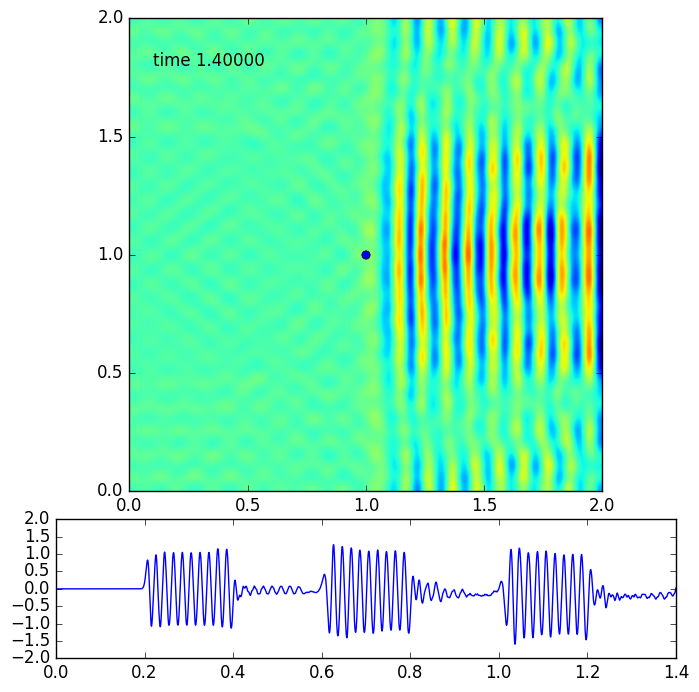

In [3]:
#setup the graphical interface 
w_wavelength=widgets.FloatSlider(description="Wavelength",value=.5,min=0.1,max=1)
w_sizeemit=widgets.FloatSlider(description="Emitter Size in (%)",value=50,min=1,max=100)
w_sourceduration=widgets.FloatSlider(description="Emission Duration in Periods",value=1,min=0.5,max=10)
w_simduration=widgets.FloatSlider(description="Simulation Duration",value=.25,min=0.1,max=10)
w_cfl=widgets.FloatSlider(description="Simulation Duration",value=.25,min=0.1,max=10)
w_saveplots=widgets.Checkbox(description="Save Images",value=False)
w_position=widgets.RadioButtons(description="Source Position",options=["Left", "Center"],value="Center")
w_start=widgets.Button(description="Start Simulation")
w_start.on_click(solvewave)
w_probex=widgets.FloatSlider(description="Probe Position",value=0.5,min=0.,max=2.)
page1=widgets.Box([w_wavelength,w_sizeemit,w_sourceduration,w_simduration,w_position])
page2=widgets.Box([w_position])
page3=widgets.Box([w_saveplots,w_probex])
tabs = widgets.Tab(children=[page1, page2, page3])
tabs.set_title(0, 'Wave')
tabs.set_title(1, 'Source')
tabs.set_title(2, 'Record')

display.display(tabs)
display.display(w_start)